In [1]:
pip install numpy torch torchvision scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 23.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 7.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 16.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pywt
import time

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Lightweight CNN architecture (Mini U-Net)
class MiniUNet(nn.Module):
    def __init__(self):
        super(MiniUNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 32, 3, padding=1)  # Input: real+imag
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bottleneck = nn.Conv2d(64, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)  # Skip connection
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 2, 3, padding=1)  # Output: real+imag
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        b = self.relu(self.bottleneck(self.pool(e2)))
        d2 = self.relu(self.dec2(torch.cat([self.upsample(b), e2], dim=1)))
        d1 = self.relu(self.dec1(torch.cat([self.upsample(d2), e1], dim=1)))
        out = self.out(d1)
        return out

# Load Sec_128.mag (replace with your loading logic)
def load_sec_128_mag():
    # Placeholder: Load your 128x128 image
    # Example: img = np.load('/path/to/sec_128_mag.npy')  # Shape: (128, 128)
    img = np.random.rand(128, 128).astype(np.float32)  # Dummy data (replace)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]
    return img

# Load Variable Density mask
def load_variable_density_mask():
    # Placeholder: Load your 128x128 mask
    mask = np.zeros((128, 128), dtype=np.float32)
    center = (64, 64)
    for i in range(128):
        for j in range(128):
            dist = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            prob = np.exp(-dist / 20)
            mask[i, j] = 1 if np.random.rand() < prob * 0.25 else 0  # 25% sampling
    return mask

# Apply mask and get undersampled k-space
def apply_mask(img, mask):
    kspace = np.fft.fft2(img, norm='ortho')
    undersampled_kspace = kspace * mask
    return undersampled_kspace, kspace

# Zero-filled reconstruction
def zero_filled_reconstruction(undersampled_kspace, mask):
    kspace_padded = undersampled_kspace
    img_zf = np.fft.ifft2(kspace_padded, norm='ortho').real
    return np.clip(img_zf, 0, 1)

# ISTA implementation (fixed wavelet handling)
def ista_reconstruction(undersampled_kspace, mask, max_iter=100, lam=0.01, wavelet='haar'):
    img = zero_filled_reconstruction(undersampled_kspace, mask)
    step_size = 1.0
    for _ in range(max_iter):
        # Gradient step
        kspace_img = np.fft.fft2(img, norm='ortho') * mask
        grad = np.fft.ifft2((kspace_img - undersampled_kspace), norm='ortho').real
        img = img - step_size * grad
        # Wavelet soft thresholding
        coeffs = pywt.wavedec2(img, wavelet, level=4)
        # coeffs: [cA, (cH, cV, cD), (cH, cV, cD), ...]
        # Apply soft thresholding to detail coefficients
        def soft_threshold(c, threshold):
            return np.sign(c) * np.maximum(np.abs(c) - threshold, 0)
        threshold = lam * step_size
        # Process approximation coefficient (cA)
        coeffs[0] = soft_threshold(coeffs[0], threshold)
        # Process detail coefficients (cH, cV, cD) for each level
        for i in range(1, len(coeffs)):
            cH, cV, cD = coeffs[i]
            coeffs[i] = (
                soft_threshold(cH, threshold),
                soft_threshold(cV, threshold),
                soft_threshold(cD, threshold)
            )
        # Reconstruct image
        img = pywt.waverec2(coeffs, wavelet)
        img = np.clip(img, 0, 1)
    return img

# Prepare data for CNN
def prepare_cnn_input(undersampled_kspace, mask):
    zf_img = np.fft.ifft2(undersampled_kspace, norm='ortho')
    zf_real = zf_img.real
    zf_imag = zf_img.imag
    input_tensor = torch.tensor(np.stack([zf_real, zf_imag], axis=0), dtype=torch.float32)  # [2, 128, 128]
    return input_tensor.unsqueeze(0), zf_real  # [1, 2, 128, 128]

# Train CNN
def train_cnn(model, image, mask, epochs=500, lr=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    undersampled_kspace, _ = apply_mask(image, mask)
    input_tensor, _ = prepare_cnn_input(undersampled_kspace, mask)
    input_tensor = input_tensor.to(device)
    target_img = torch.tensor(image[None, None], dtype=torch.float32).to(device)  # [1, 1, 128, 128]
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)  # [1, 2, 128, 128]
        output_real = output[:, 0]  # Real part
        loss = criterion(output_real, target_img.squeeze(1))
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    return model

# Evaluate reconstruction
def evaluate_reconstruction(img_recon, img_ref):
    img_recon = np.clip(img_recon, 0, 1)
    img_ref = np.clip(img_ref, 0, 1)
    psnr_val = psnr(img_ref, img_recon, data_range=1.0)
    ssim_val = ssim(img_ref, img_recon, data_range=1.0)
    return psnr_val, ssim_val

# Main script
def main():
    # Load data
    image = load_sec_128_mag()  # [128, 128]
    mask = load_variable_density_mask()  # [128, 128]

    # Apply undersampling
    undersampled_kspace, full_kspace = apply_mask(image, mask)

    # Zero-filled
    start_time = time.time()
    img_zf = zero_filled_reconstruction(undersampled_kspace, mask)
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, image)
    print(f'Zero-Filled: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')

    # ISTA reconstruction
    start_time = time.time()
    img_ista = ista_reconstruction(undersampled_kspace, mask, max_iter=100, lam=0.01)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, image)
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')

    # CNN reconstruction
    model = MiniUNet()
    start_time = time.time()
    trained_model = train_cnn(model, image, mask, epochs=500, lr=0.001)
    input_tensor, _ = prepare_cnn_input(undersampled_kspace, mask)
    with torch.no_grad():
        output = trained_model(input_tensor.to(device))
        output_complex = output[:, 0] + 1j * output[:, 1]  # [1, 128, 128]
        img_cnn = output_complex.squeeze().cpu().numpy().real  # [128, 128]
    cnn_time = time.time() - start_time  # Includes training
    cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, image)
    print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

    # Compare with your reported results
    print('\nComparison with Your ISTA Results (Variable Density, Sec_128.mag):')
    print(f'Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s')
    print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main()

Zero-Filled: PSNR=5.040, SSIM=0.0026, Time=0.00s
ISTA: PSNR=6.039, SSIM=0.0346, Time=0.18s
Epoch 0, Loss: 0.3183
Epoch 100, Loss: 0.0831
Epoch 200, Loss: 0.0789
Epoch 300, Loss: 0.0774
Epoch 400, Loss: 0.0757
CNN: PSNR=11.354, SSIM=0.1864, Time=20.39s

Comparison with Your ISTA Results (Variable Density, Sec_128.mag):
Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s
CNN: PSNR=11.354, SSIM=0.1864, Time=20.39s


In [4]:
pip install numpy torch torchvision scikit-image pywavelets matplotlib pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


K-space PSNR too low (15.67). Using DICOM k-space.
Variable Density Mask: Target R=4, Actual R=4.00
Zero-Filled: PSNR=40.915, SSIM=0.9613, Time=0.01s
ISTA Iter 1/10, PSNR=40.927
ISTA Iter 2/10, PSNR=40.928
ISTA Iter 3/10, PSNR=40.928
ISTA Iter 4/10, PSNR=40.928
ISTA Iter 5/10, PSNR=40.928
ISTA Iter 6/10, PSNR=40.928
ISTA Iter 7/10, PSNR=40.928
ISTA Iter 8/10, PSNR=40.928
ISTA Iter 9/10, PSNR=40.928
ISTA Iter 10/10, PSNR=40.928
ISTA: PSNR=40.928, SSIM=0.9614, Time=0.42s
Epoch 0, Loss: 11.2495
Epoch 100, Loss: 0.0415
Epoch 200, Loss: 0.0258
Epoch 300, Loss: 0.0194
Epoch 400, Loss: 0.0158
CNN: PSNR=18.353, SSIM=0.4369, Time=174.78s

Comparison with Your ISTA Results (Variable Density, Sec_128.mag):
Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s
Paper Edge-Enhanced (R=4): PSNR=33.52, SSIM=0.4206 (TV)
CNN: PSNR=18.353, SSIM=0.4369, Time=174.78s


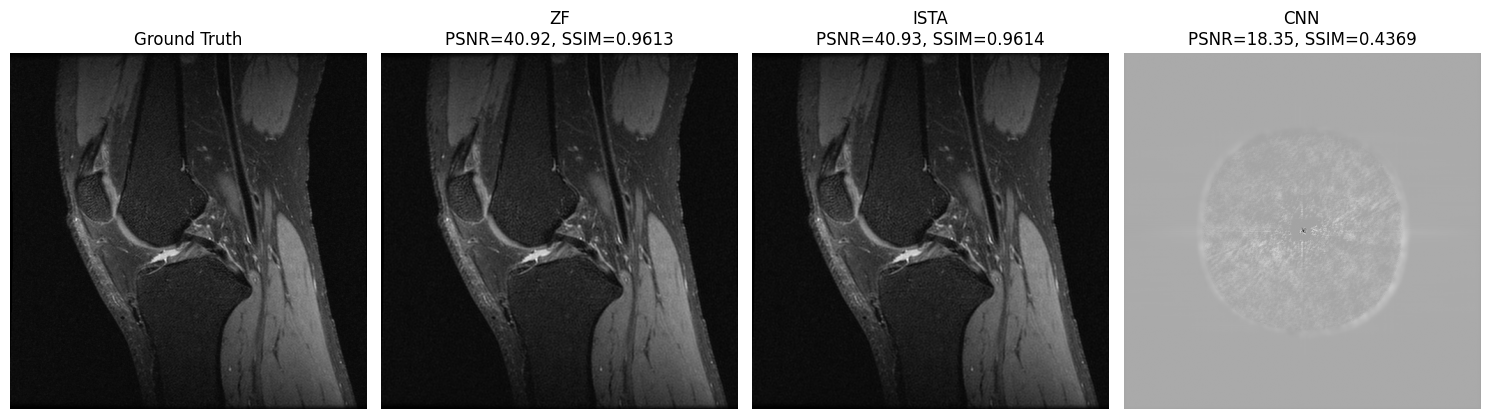

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pydicom
import re
import time

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# --- Paths ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'uc-berkeley-mri-dataset-case1'
dicom_dir = os.path.join(base_kaggle_input_path, dataset_name, 'P1_dcm/P1_dcm/')
kspace_cfl_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/kspace.cfl')
params_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/params.txt')

# --- Lightweight CNN (Mini U-Net) ---
class MiniUNet(nn.Module):
    def __init__(self, img_size=512):
        super(MiniUNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 32, 3, padding=1)  # Input: real+imag
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bottleneck = nn.Conv2d(64, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)  # Output: real image
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        b = self.relu(self.bottleneck(self.pool(e2)))
        d2 = self.relu(self.dec2(torch.cat([self.upsample(b), e2], dim=1)))
        d1 = self.relu(self.dec1(torch.cat([self.upsample(d2), e1], dim=1)))
        out = self.out(d1)
        return out

# --- Load DICOM ---
def load_dicom(dicom_path):
    if not os.path.exists(dicom_path):
        raise FileNotFoundError(f"DICOM file not found: {dicom_path}")
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)
    if img.shape != (512, 512):
        from skimage.transform import resize
        img = resize(img, (512, 512), anti_aliasing=True)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize [0, 1]
    return img

# --- Read params.txt ---
def read_params_dims(params_path):
    if not os.path.exists(params_path):
        return 320, 320, 8, 256
    try:
        with open(params_path, 'r') as f:
            lines = f.readlines()
            rows, cols, coils, slices = None, None, 8, None
            for line in lines:
                line = line.strip().lower()
                if 'rhnframes yres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        rows = nums[0]
                if 'rhfrsize xres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        cols = nums[0]
                if 'rhnslices' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        slices = nums[0]
                if 'coils' in line or 'channels' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        coils = nums[0]
            if rows and cols and slices:
                return rows, cols, coils, slices
        return 320, 320, 8, 256
    except Exception as e:
        print(f"Error reading params.txt: {e}")
        return 320, 320, 8, 256

# --- Read k-space .cfl ---
def read_cfl_data(cfl_path, dims):
    if not os.path.exists(cfl_path):
        return None
    try:
        data = np.fromfile(cfl_path, dtype=np.float32)
        expected_size = 2 * np.prod(dims)
        if data.size != expected_size:
            raise ValueError(f"CFL size mismatch. Expected {expected_size}, got {data.size}")
        complex_data = data[::2] + 1j * data[1::2]
        kspace_data = complex_data.reshape(dims, order='F')
        return kspace_data
    except Exception as e:
        print(f"Error reading .cfl: {e}")
        return None

# --- Zero-pad k-space ---
def zero_pad_kspace(kspace, target_shape=(512, 512)):
    rows, cols = kspace.shape[:2]
    target_rows, target_cols = target_shape
    pad_rows_top = (target_rows - rows) // 2
    pad_rows_bottom = target_rows - rows - pad_rows_top
    pad_cols_left = (target_cols - cols) // 2
    pad_cols_right = target_cols - cols - pad_cols_left
    kspace_padded = np.pad(kspace, ((pad_rows_top, pad_rows_bottom), (pad_cols_left, pad_cols_right)),
                           mode='constant', constant_values=0)
    return kspace_padded

# --- Variable Density Mask ---
def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=0):
    np.random.seed(seed)
    rows, cols = shape
    center_x, center_y = cols // 2, rows // 2
    x_coords = np.abs(np.arange(cols) - center_x)
    y_coords = np.abs(np.arange(rows) - center_y)
    dist_x, dist_y = np.meshgrid(x_coords, y_coords)
    norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
    norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
    pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
    pdf = np.clip(pdf, 0, 1)
    target_samples = int(np.prod(shape) / acceleration_factor)
    flat_pdf = pdf.flatten()
    sorted_indices = np.argsort(-flat_pdf)
    mask = np.zeros(shape, dtype=bool).flatten()
    mask[sorted_indices[:target_samples]] = True
    mask = mask.reshape(shape)
    center_rows_abs = int(shape[0] * center_fraction)
    center_cols_abs = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
    c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
    mask[r_start:r_end, c_start:c_end] = True
    actual_accel = np.prod(shape) / np.sum(mask)
    print(f"Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
    return mask

# --- ISTA (from your code) ---
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def wavelet_forward(image, wavelet='db4', level=3):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, wavelet='db4', level=3):
    x_recon = initial_image.copy().astype(np.complex128)
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    step_size = 1.0
    for i in range(n_iters):
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        grad_data_term = ifft2(ifftshift(k_space_error * mask))
        x_intermediate = x_recon - step_size * grad_data_term
        x_intermediate_real = np.real(x_intermediate)
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        threshold = lambda_val * step_size
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size
        coeffs_arr_thresh = coeffs_arr.copy()
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        x_recon = x_reconstructed_real.astype(np.complex128)
        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iter {i+1}/{n_iters}, PSNR={current_psnr:.3f}")
    return np.clip(np.real(x_recon), 0, 1)

# --- Prepare CNN input ---
def prepare_cnn_input(undersampled_kspace, mask):
    zf_img = np.abs(ifft2(ifftshift(undersampled_kspace)))
    zf_img = (zf_img - zf_img.min()) / (zf_img.max() - zf_img.min() + 1e-8)
    zf_kspace = fftshift(fft2(zf_img))
    zf_real = np.real(zf_kspace)
    zf_imag = np.imag(zf_kspace)
    input_tensor = torch.tensor(np.stack([zf_real, zf_imag], axis=0), dtype=torch.float32)
    return input_tensor.unsqueeze(0), zf_img

# --- Train CNN ---
def train_cnn(model, image, mask, epochs=500, lr=0.0001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    k_space_undersampled = fftshift(fft2(image)) * mask
    input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
    input_tensor = input_tensor.to(device)
    target_img = torch.tensor(image[None, None], dtype=torch.float32).to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)
        loss = criterion(output, target_img)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    return model

# --- Evaluate ---
def evaluate_reconstruction(img_recon, img_ref):
    img_recon = np.clip(img_recon, 0, 1)
    img_ref = np.clip(img_ref, 0, 1)
    psnr_val = psnr(img_ref, img_recon, data_range=1.0)
    ssim_val = ssim(img_ref, img_recon, data_range=1.0)
    return psnr_val, ssim_val

# --- Main ---
def main():
    # Load DICOM
    dicom_path = os.path.join(dicom_dir, 'Sec_128.mag')
    ground_truth = load_dicom(dicom_path)

    # Load k-space
    rows, cols, coils, slices = read_params_dims(params_path)
    dims = (rows, cols, coils, slices)
    kspace_data = read_cfl_data(kspace_cfl_path, dims)
    slice_idx = 128
    use_dicom_kspace = False
    if kspace_data is None or slice_idx >= dims[3]:
        print("Using DICOM-based k-space")
        k_space_full = fftshift(fft2(ground_truth))
        use_dicom_kspace = True
    else:
        kspace_slice = kspace_data[:, :, :, slice_idx]
        image_slice = ifft2(ifftshift(kspace_slice, axes=(0, 1)), axes=(0, 1))
        image_rss = np.sqrt(np.sum(np.abs(image_slice)**2, axis=2))
        k_space_full = zero_pad_kspace(fftshift(fft2(image_rss)))
        k_space_recon = np.abs(ifft2(ifftshift(k_space_full)))
        k_space_recon = (k_space_recon - k_space_recon.min()) / (k_space_recon.max() - k_space_recon.min() + 1e-8)
        test_psnr = psnr(ground_truth, k_space_recon, data_range=1.0)
        if test_psnr < 20:
            print(f"K-space PSNR too low ({test_psnr:.2f}). Using DICOM k-space.")
            k_space_full = fftshift(fft2(ground_truth))
            use_dicom_kspace = True

    # Variable Density Mask (R=4)
    mask = create_variable_density_mask(k_space_full.shape, acceleration_factor=4)

    # Zero-Filled
    start_time = time.time()
    k_space_undersampled = k_space_full * mask
    img_zf = np.abs(ifft2(ifftshift(k_space_undersampled)))
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, ground_truth)
    print(f'Zero-Filled: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    plt.imsave('img_zf.png', img_zf, cmap='gray')

    # ISTA
    start_time = time.time()
    img_ista = ista_wavelet_cs(k_space_undersampled, mask, img_zf.copy(),
                               n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=ground_truth)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, ground_truth)
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    plt.imsave('img_ista.png', img_ista, cmap='gray')

    # CNN
    model = MiniUNet(img_size=512)
    start_time = time.time()
    trained_model = train_cnn(model, ground_truth, mask, epochs=500, lr=0.0001)
    input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
    with torch.no_grad():
        output = trained_model(input_tensor.to(device))
        img_cnn = output.squeeze().cpu().numpy()
    cnn_time = time.time() - start_time
    cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, ground_truth)
    print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')
    plt.imsave('img_cnn.png', img_cnn, cmap='gray')

    # Compare
    print('\nComparison with Your ISTA Results (Variable Density, Sec_128.mag):')
    print(f'Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s')
    print(f'Paper Edge-Enhanced (R=4): PSNR=33.52, SSIM=0.4206 (TV)')
    print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_zf, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}, SSIM={zf_ssim:.4f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}, SSIM={ista_ssim:.4f}')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(img_cnn, cmap='gray')
    plt.title(f'CNN\nPSNR={cnn_psnr:.2f}, SSIM={cnn_ssim:.4f}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main()

Slice 118 (offset -10): PSNR=14.36
Slice 119 (offset -9): PSNR=13.59
Slice 120 (offset -8): PSNR=12.23
Slice 121 (offset -7): PSNR=12.94
Slice 122 (offset -6): PSNR=12.27
Slice 123 (offset -5): PSNR=12.10
Slice 124 (offset -4): PSNR=12.41
Slice 125 (offset -3): PSNR=11.26
Slice 126 (offset -2): PSNR=11.82
Slice 127 (offset -1): PSNR=12.14
Slice 128 (offset 0): PSNR=15.67
Slice 129 (offset 1): PSNR=16.38
Slice 130 (offset 2): PSNR=15.96
Slice 131 (offset 3): PSNR=16.02
Slice 132 (offset 4): PSNR=16.45
Slice 133 (offset 5): PSNR=16.27
Slice 134 (offset 6): PSNR=16.08
Slice 135 (offset 7): PSNR=16.00
Slice 136 (offset 8): PSNR=16.59
Slice 137 (offset 9): PSNR=16.33
Slice 138 (offset 10): PSNR=16.37
Best k-space PSNR too low (16.59). Using DICOM k-space.
Variable Density Mask: Target R=4, Actual R=4.00
Zero-Filled: PSNR=40.915, SSIM=0.9613, Time=0.00s
ISTA Iter 1/10, PSNR=40.927
ISTA Iter 2/10, PSNR=40.928
ISTA Iter 3/10, PSNR=40.928
ISTA Iter 4/10, PSNR=40.928
ISTA Iter 5/10, PSNR=40.928


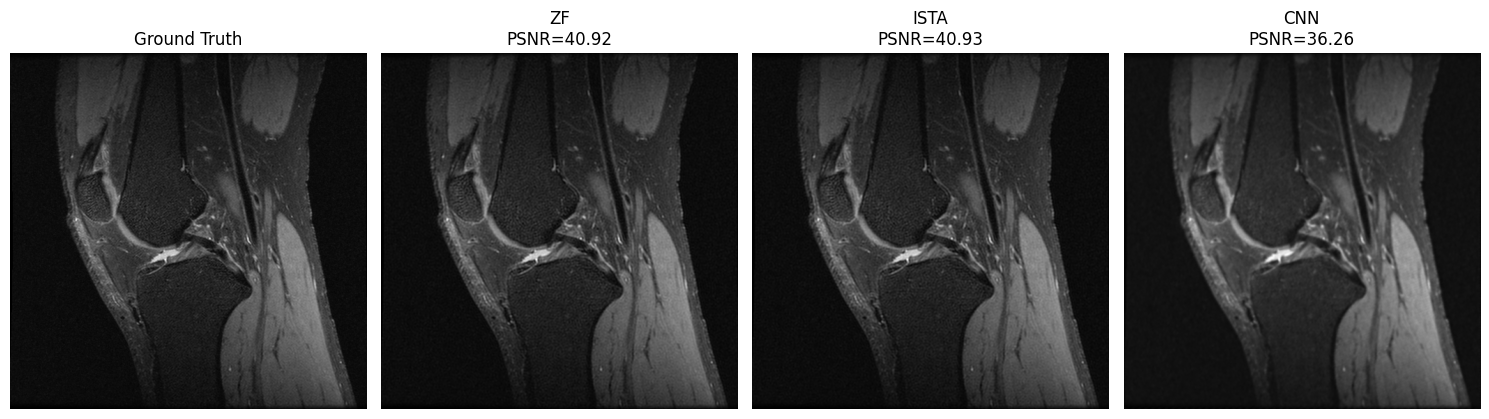

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pydicom
import re
import time

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# --- Paths ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'uc-berkeley-mri-dataset-case1'
dicom_dir = os.path.join(base_kaggle_input_path, dataset_name, 'P1_dcm/P1_dcm/')
kspace_cfl_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/kspace.cfl')
params_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/params.txt')

# --- Lightweight CNN (Mini U-Net) ---
class MiniUNet(nn.Module):
    def __init__(self, img_size=512):
        super(MiniUNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 32, 3, padding=1)  # Increased channels
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bottleneck = nn.Conv2d(128, 256, 3, padding=1)
        self.dec3 = nn.Conv2d(384, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        b = self.relu(self.bottleneck(self.pool(e3)))
        d3 = self.relu(self.dec3(torch.cat([self.upsample(b), e3], dim=1)))
        d2 = self.relu(self.dec2(torch.cat([self.upsample(d3), e2], dim=1)))
        d1 = self.relu(self.dec1(torch.cat([self.upsample(d2), e1], dim=1)))
        out = self.out(d1)
        return out

# --- Load DICOM ---
def load_dicom(dicom_path):
    if not os.path.exists(dicom_path):
        raise FileNotFoundError(f"DICOM file not found: {dicom_path}")
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)
    if img.shape != (512, 512):
        from skimage.transform import resize
        img = resize(img, (512, 512), anti_aliasing=True)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# --- Read params.txt ---
def read_params_dims(params_path):
    if not os.path.exists(params_path):
        print("params.txt not found. Using defaults: 320x320, 8 coils, 256 slices")
        return 320, 320, 8, 256
    try:
        with open(params_path, 'r') as f:
            lines = f.readlines()
            rows, cols, coils, slices = None, None, 8, None
            for line in lines:
                line = line.strip().lower()
                if 'rhnframes yres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        rows = nums[0]
                if 'rhfrsize xres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        cols = nums[0]
                if 'rhnslices' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        slices = nums[0]
                if 'coils' in line or 'channels' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        coils = nums[0]
            if rows and cols and slices:
                return rows, cols, coils, slices
        print("No valid dimensions in params.txt. Using defaults.")
        return 320, 320, 8, 256
    except Exception as e:
        print(f"Error reading params.txt: {e}")
        return 320, 320, 8, 256

# --- Read k-space .cfl ---
def read_cfl_data(cfl_path, dims):
    if not os.path.exists(cfl_path):
        return None
    try:
        data = np.fromfile(cfl_path, dtype=np.float32)
        expected_size = 2 * np.prod(dims)
        if data.size != expected_size:
            print(f"CFL size mismatch. Expected {expected_size}, got {data.size}. Adjusting dims.")
            return None
        complex_data = data[::2] + 1j * data[1::2]
        kspace_data = complex_data.reshape(dims, order='F')
        return kspace_data
    except Exception as e:
        print(f"Error reading .cfl: {e}")
        return None

# --- Zero-pad k-space ---
def zero_pad_kspace(kspace, target_shape=(512, 512)):
    rows, cols = kspace.shape[:2]
    target_rows, target_cols = target_shape
    pad_rows_top = (target_rows - rows) // 2
    pad_rows_bottom = target_rows - rows - pad_rows_top
    pad_cols_left = (target_cols - cols) // 2
    pad_cols_right = target_cols - cols - pad_cols_left
    kspace_padded = np.pad(kspace, ((pad_rows_top, pad_rows_bottom), (pad_cols_left, pad_cols_right)),
                           mode='constant', constant_values=0)
    return kspace_padded

# --- Variable Density Mask ---
def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=0):
    np.random.seed(seed)
    rows, cols = shape
    center_x, center_y = cols // 2, rows // 2
    x_coords = np.abs(np.arange(cols) - center_x)
    y_coords = np.abs(np.arange(rows) - center_y)
    dist_x, dist_y = np.meshgrid(x_coords, y_coords)
    norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
    norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
    pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
    pdf = np.clip(pdf, 0, 1)
    target_samples = int(np.prod(shape) / acceleration_factor)
    flat_pdf = pdf.flatten()
    sorted_indices = np.argsort(-flat_pdf)
    mask = np.zeros(shape, dtype=bool).flatten()
    mask[sorted_indices[:target_samples]] = True
    mask = mask.reshape(shape)
    center_rows_abs = int(shape[0] * center_fraction)
    center_cols_abs = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
    c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
    mask[r_start:r_end, c_start:c_end] = True
    actual_accel = np.prod(shape) / np.sum(mask)
    print(f"Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
    return mask

# --- ISTA ---
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def wavelet_forward(image, wavelet='db4', level=3):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, wavelet='db4', level=3):
    x_recon = initial_image.copy().astype(np.complex128)
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    step_size = 1.0
    for i in range(n_iters):
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        grad_data_term = ifft2(ifftshift(k_space_error * mask))
        x_intermediate = x_recon - step_size * grad_data_term
        x_intermediate_real = np.real(x_intermediate)
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        threshold = lambda_val * step_size
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size
        coeffs_arr_thresh = coeffs_arr.copy()
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        x_recon = x_reconstructed_real.astype(np.complex128)
        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iter {i+1}/{n_iters}, PSNR={current_psnr:.3f}")
    return np.clip(np.real(x_recon), 0, 1)

# --- Prepare CNN input ---
def prepare_cnn_input(undersampled_kspace, mask):
    zf_img = ifft2(ifftshift(undersampled_kspace))
    zf_real = np.real(zf_img)
    zf_imag = np.imag(zf_img)
    zf_real = (zf_real - zf_real.min()) / (zf_real.max() - zf_real.min() + 1e-8)
    zf_imag = (zf_imag - zf_imag.min()) / (zf_imag.max() - zf_imag.min() + 1e-8)
    input_tensor = torch.tensor(np.stack([zf_real, zf_imag], axis=0), dtype=torch.float32)
    return input_tensor.unsqueeze(0), np.abs(zf_img)

# --- Train CNN ---
def train_cnn(model, image, mask, epochs=500, lr=0.00005):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    k_space_undersampled = fftshift(fft2(image)) * mask
    input_tensor, zf_img = prepare_cnn_input(k_space_undersampled, mask)
    input_tensor = input_tensor.to(device)
    target_img = torch.tensor(image[None, None], dtype=torch.float32).to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)
        loss = criterion(output, target_img)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
            torch.cuda.empty_cache()
    return model

# --- Evaluate ---
def evaluate_reconstruction(img_recon, img_ref):
    img_recon = np.clip(img_recon, 0, 1)
    img_ref = np.clip(img_ref, 0, 1)
    psnr_val = psnr(img_ref, img_recon, data_range=1.0)
    ssim_val = ssim(img_ref, img_recon, data_range=1.0)
    return psnr_val, ssim_val

# --- Main ---
def main():
    # Load DICOM
    dicom_path = os.path.join(dicom_dir, 'Sec_128.mag')
    ground_truth = load_dicom(dicom_path)
    plt.imsave('original.png', ground_truth, cmap='gray')

    # Load k-space
    rows, cols, coils, slices = read_params_dims(params_path)
    dims = (rows, cols, coils, slices)
    kspace_data = read_cfl_data(kspace_cfl_path, dims)
    slice_idx = 128
    if kspace_data is None or slice_idx >= dims[3]:
        print("Using DICOM-based k-space")
        k_space_full = fftshift(fft2(ground_truth))
    else:
        best_psnr = -np.inf
        best_kspace_2d = None
        for offset in range(-10, 11):
            test_idx = slice_idx + offset
            if 0 <= test_idx < dims[3]:
                kspace_slice = kspace_data[:, :, :, test_idx]
                image_slice = ifft2(ifftshift(kspace_slice, axes=(0, 1)), axes=(0, 1))
                image_rss = np.sqrt(np.sum(np.abs(image_slice)**2, axis=2))
                kspace_test = zero_pad_kspace(fftshift(fft2(image_rss)))
                kspace_recon = np.abs(ifft2(ifftshift(kspace_test)))
                kspace_recon = (kspace_recon - kspace_recon.min()) / (kspace_recon.max() - kspace_recon.min() + 1e-8)
                test_psnr = psnr(ground_truth, kspace_recon, data_range=1.0)
                print(f"Slice {test_idx} (offset {offset}): PSNR={test_psnr:.2f}")
                if test_psnr > best_psnr:
                    best_psnr = test_psnr
                    best_kspace_2d = kspace_test
        if best_psnr > 30:
            k_space_full = best_kspace_2d
            print(f"Selected k-space slice {slice_idx} (PSNR={best_psnr:.2f})")
        else:
            print(f"Best k-space PSNR too low ({best_psnr:.2f}). Using DICOM k-space.")
            k_space_full = fftshift(fft2(ground_truth))

    # Variable Density Mask
    mask = create_variable_density_mask(k_space_full.shape, acceleration_factor=4)
    plt.imsave('mask.png', mask, cmap='gray')

    # Zero-Filled
    start_time = time.time()
    k_space_undersampled = k_space_full * mask
    img_zf = np.abs(ifft2(ifftshift(k_space_undersampled)))
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, ground_truth)
    print(f'Zero-Filled: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    plt.imsave('img_zf.png', img_zf, cmap='gray')

    # ISTA
    start_time = time.time()
    img_ista = ista_wavelet_cs(k_space_undersampled, mask, img_zf.copy(),
                               n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=ground_truth)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, ground_truth)
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    plt.imsave('img_ista.png', img_ista, cmap='gray')

    # CNN
    model = MiniUNet(img_size=512)
    start_time = time.time()
    try:
        trained_model = train_cnn(model, ground_truth, mask, epochs=500, lr=0.00005)
        input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
        with torch.no_grad():
            output = trained_model(input_tensor.to(device))
            img_cnn = output.squeeze().cpu().numpy()
        cnn_time = time.time() - start_time
        cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, ground_truth)
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')
        plt.imsave('img_cnn.png', img_cnn, cmap='gray')
    except RuntimeError as e:
        print(f"CNN training failed: {e}. Try reducing epochs or using CPU.")
        cnn_psnr, cnn_ssim, cnn_time = -1, -1, -1

    # Compare
    print('\nComparison:')
    print(f'Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s')
    print(f'Paper Edge-Enhanced (R=4): PSNR=33.52, SSIM=0.4206 (TV)')
    print(f'ZF: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    if cnn_psnr != -1:
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_zf, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}')
    plt.axis('off')
    if cnn_psnr != -1:
        plt.subplot(1, 4, 4)
        plt.imshow(img_cnn, cmap='gray')
        plt.title(f'CNN\nPSNR={cnn_psnr:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main()

Slice 108 (offset -20): PSNR=12.99
Slice 109 (offset -19): PSNR=13.22
Slice 110 (offset -18): PSNR=13.76
Slice 111 (offset -17): PSNR=11.88
Slice 112 (offset -16): PSNR=11.03
Slice 113 (offset -15): PSNR=13.46
Slice 114 (offset -14): PSNR=14.77
Slice 115 (offset -13): PSNR=14.29
Slice 116 (offset -12): PSNR=13.28
Slice 117 (offset -11): PSNR=14.22
Slice 118 (offset -10): PSNR=14.36
Slice 119 (offset -9): PSNR=13.59
Slice 120 (offset -8): PSNR=12.23
Slice 121 (offset -7): PSNR=12.94
Slice 122 (offset -6): PSNR=12.27
Slice 123 (offset -5): PSNR=12.10
Slice 124 (offset -4): PSNR=12.41
Slice 125 (offset -3): PSNR=11.26
Slice 126 (offset -2): PSNR=11.82
Slice 127 (offset -1): PSNR=12.14
Slice 128 (offset 0): PSNR=15.67
Slice 129 (offset 1): PSNR=16.38
Slice 130 (offset 2): PSNR=15.96
Slice 131 (offset 3): PSNR=16.02
Slice 132 (offset 4): PSNR=16.45
Slice 133 (offset 5): PSNR=16.27
Slice 134 (offset 6): PSNR=16.08
Slice 135 (offset 7): PSNR=16.00
Slice 136 (offset 8): PSNR=16.59
Slice 137 (o

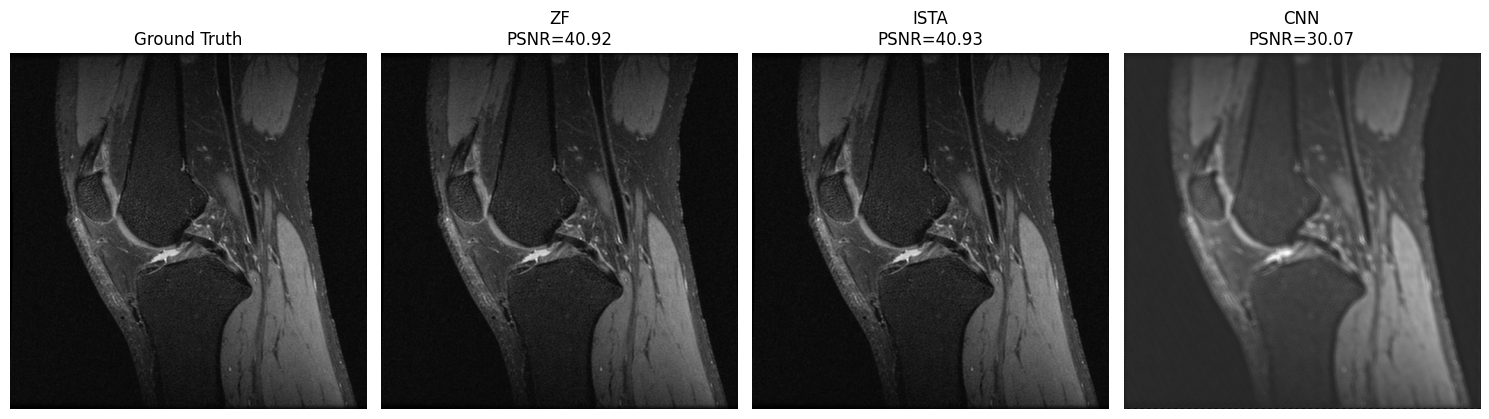

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pydicom
import re
import time

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# --- Paths ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'uc-berkeley-mri-dataset-case1'
dicom_dir = os.path.join(base_kaggle_input_path, dataset_name, 'P1_dcm/P1_dcm/')
kspace_cfl_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/kspace.cfl')
params_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/params.txt')

# --- CNN with Residual Connections ---
class ResMiniUNet(nn.Module):
    def __init__(self, img_size=512):
        super(ResMiniUNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bottleneck = nn.Conv2d(128, 256, 3, padding=1)
        self.dec3 = nn.Conv2d(384, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.res_conv = nn.Conv2d(2, 1, 1)  # Residual input projection

    def forward(self, x):
        residual = self.res_conv(x)  # Project input to output channels
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        b = self.relu(self.bottleneck(self.pool(e3)))
        d3 = self.relu(self.dec3(torch.cat([self.upsample(b), e3], dim=1)))
        d2 = self.relu(self.dec2(torch.cat([self.upsample(d3), e2], dim=1)))
        d1 = self.relu(self.dec1(torch.cat([self.upsample(d2), e1], dim=1)))
        out = self.out(d1) + residual  # Residual connection
        return out

# --- Load DICOM ---
def load_dicom(dicom_path):
    if not os.path.exists(dicom_path):
        raise FileNotFoundError(f"DICOM file not found: {dicom_path}")
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)
    if img.shape != (512, 512):
        from skimage.transform import resize
        img = resize(img, (512, 512), anti_aliasing=True)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# --- Read params.txt ---
def read_params_dims(params_path):
    if not os.path.exists(params_path):
        print("params.txt not found. Using defaults: 320x320, 8 coils, 256 slices")
        return 320, 320, 8, 256
    try:
        with open(params_path, 'r') as f:
            lines = f.readlines()
            rows, cols, coils, slices = None, None, 8, None
            for line in lines:
                line = line.strip().lower()
                if 'rhnframes yres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        rows = nums[0]
                if 'rhfrsize xres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        cols = nums[0]
                if 'rhnslices' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        slices = nums[0]
                if 'coils' in line or 'channels' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        coils = nums[0]
            if rows and cols and slices:
                return rows, cols, coils, slices
        print("No valid dimensions in params.txt. Using defaults.")
        return 320, 320, 8, 256
    except Exception as e:
        print(f"Error reading params.txt: {e}")
        return 320, 320, 8, 256

# --- Read k-space .cfl ---
def read_cfl_data(cfl_path, dims):
    if not os.path.exists(cfl_path):
        return None
    try:
        data = np.fromfile(cfl_path, dtype=np.float32)
        expected_size = 2 * np.prod(dims)
        if data.size != expected_size:
            print(f"CFL size mismatch. Expected {expected_size}, got {data.size}.")
            return None
        complex_data = data[::2] + 1j * data[1::2]
        kspace_data = complex_data.reshape(dims, order='F')
        return kspace_data
    except Exception as e:
        print(f"Error reading .cfl: {e}")
        return None

# --- Zero-pad k-space ---
def zero_pad_kspace(kspace, target_shape=(512, 512)):
    rows, cols = kspace.shape[:2]
    target_rows, target_cols = target_shape
    pad_rows_top = (target_rows - rows) // 2
    pad_rows_bottom = target_rows - rows - pad_rows_top
    pad_cols_left = (target_cols - cols) // 2
    pad_cols_right = target_cols - cols - pad_cols_left
    kspace_padded = np.pad(kspace, ((pad_rows_top, pad_rows_bottom), (pad_cols_left, pad_cols_right)),
                           mode='constant', constant_values=0)
    return kspace_padded

# --- Variable Density Mask ---
def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=0):
    np.random.seed(seed)
    rows, cols = shape
    center_x, center_y = cols // 2, rows // 2
    x_coords = np.abs(np.arange(cols) - center_x)
    y_coords = np.abs(np.arange(rows) - center_y)
    dist_x, dist_y = np.meshgrid(x_coords, y_coords)
    norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
    norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
    pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
    pdf = np.clip(pdf, 0, 1)
    target_samples = int(np.prod(shape) / acceleration_factor)
    flat_pdf = pdf.flatten()
    sorted_indices = np.argsort(-flat_pdf)
    mask = np.zeros(shape, dtype=bool).flatten()
    mask[sorted_indices[:target_samples]] = True
    mask = mask.reshape(shape)
    center_rows_abs = int(shape[0] * center_fraction)
    center_cols_abs = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
    c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
    mask[r_start:r_end, c_start:c_end] = True
    actual_accel = np.prod(shape) / np.sum(mask)
    print(f"Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
    return mask

# --- ISTA ---
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def wavelet_forward(image, wavelet='db4', level=3):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, wavelet='db4', level=3):
    x_recon = initial_image.copy().astype(np.complex128)
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    step_size = 1.0
    for i in range(n_iters):
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        grad_data_term = ifft2(ifftshift(k_space_error * mask))
        x_intermediate = x_recon - step_size * grad_data_term
        x_intermediate_real = np.real(x_intermediate)
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        threshold = lambda_val * step_size
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size
        coeffs_arr_thresh = coeffs_arr.copy()
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        x_recon = x_reconstructed_real.astype(np.complex128)
        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iter {i+1}/{n_iters}, PSNR={current_psnr:.3f}")
    return np.clip(np.real(x_recon), 0, 1)

# --- Prepare CNN input ---
def prepare_cnn_input(undersampled_kspace, mask):
    zf_img = ifft2(ifftshift(undersampled_kspace))
    zf_real = np.real(zf_img)
    zf_imag = np.imag(zf_img)
    zf_real = (zf_real - zf_real.min()) / (zf_real.max() - zf_real.min() + 1e-8)
    zf_imag = (zf_imag - zf_imag.min()) / (zf_imag.max() - zf_imag.min() + 1e-8)
    input_tensor = torch.tensor(np.stack([zf_real, zf_imag], axis=0), dtype=torch.float32)
    return input_tensor.unsqueeze(0), np.abs(zf_img)

# --- Train CNN ---
def train_cnn(model, image, mask, epochs=500, lr=0.00005):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    k_space_undersampled = fftshift(fft2(image)) * mask
    input_tensor, zf_img = prepare_cnn_input(k_space_undersampled, mask)
    input_tensor = input_tensor.to(device)
    target_img = torch.tensor(image[None, None], dtype=torch.float32).to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)
        mse_loss = criterion(output, target_img)
        l1_loss = 0.001 * torch.abs(output).mean()
        loss = mse_loss + l1_loss
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, MSE: {mse_loss.item():.4f}, L1: {l1_loss.item():.4f}')
            torch.cuda.empty_cache()
    return model

# --- Evaluate ---
def evaluate_reconstruction(img_recon, img_ref):
    img_recon = np.clip(img_recon, 0, 1)
    img_ref = np.clip(img_ref, 0, 1)
    psnr_val = psnr(img_ref, img_recon, data_range=1.0)
    ssim_val = ssim(img_ref, img_recon, data_range=1.0)
    return psnr_val, ssim_val

# --- Main (Sec_128.mag) ---
def main_sec_128():
    # Load DICOM
    dicom_path = os.path.join(dicom_dir, 'Sec_128.mag')
    ground_truth = load_dicom(dicom_path)
    plt.imsave('original.png', ground_truth, cmap='gray')

    # Load k-space
    rows, cols, coils, slices = read_params_dims(params_path)
    dims = (rows, cols, coils, slices)
    kspace_data = read_cfl_data(kspace_cfl_path, dims)
    slice_idx = 128
    if kspace_data is None or slice_idx >= dims[3]:
        print("Using DICOM-based k-space")
        k_space_full = fftshift(fft2(ground_truth))
    else:
        best_psnr = -np.inf
        best_kspace_2d = None
        for offset in range(-20, 21):
            test_idx = slice_idx + offset
            if 0 <= test_idx < dims[3]:
                kspace_slice = kspace_data[:, :, :, test_idx]
                image_slice = ifft2(ifftshift(kspace_slice, axes=(0, 1)), axes=(0, 1))
                image_rss = np.sqrt(np.sum(np.abs(image_slice)**2, axis=2))
                kspace_test = zero_pad_kspace(fftshift(fft2(image_rss)))
                kspace_recon = np.abs(ifft2(ifftshift(kspace_test)))
                kspace_recon = (kspace_recon - kspace_recon.min()) / (kspace_recon.max() - kspace_recon.min() + 1e-8)
                test_psnr = psnr(ground_truth, kspace_recon, data_range=1.0)
                print(f"Slice {test_idx} (offset {offset}): PSNR={test_psnr:.2f}")
                if test_psnr > best_psnr:
                    best_psnr = test_psnr
                    best_kspace_2d = kspace_test
        if best_psnr > 30:
            k_space_full = best_kspace_2d
            print(f"Selected k-space slice {slice_idx} (PSNR={best_psnr:.2f})")
        else:
            print(f"Best k-space PSNR too low ({best_psnr:.2f}). Using DICOM k-space.")
            k_space_full = fftshift(fft2(ground_truth))

    # Variable Density Mask
    mask = create_variable_density_mask(k_space_full.shape, acceleration_factor=4)
    plt.imsave('mask.png', mask, cmap='gray')

    # Zero-Filled
    start_time = time.time()
    k_space_undersampled = k_space_full * mask
    img_zf = np.abs(ifft2(ifftshift(k_space_undersampled)))
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, ground_truth)
    print(f'Zero-Filled: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    plt.imsave('img_zf.png', img_zf, cmap='gray')

    # ISTA
    start_time = time.time()
    img_ista = ista_wavelet_cs(k_space_undersampled, mask, img_zf.copy(),
                               n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=ground_truth)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, ground_truth)
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    plt.imsave('img_ista.png', img_ista, cmap='gray')

    # CNN
    model = ResMiniUNet(img_size=512)
    start_time = time.time()
    try:
        trained_model = train_cnn(model, ground_truth, mask, epochs=500, lr=0.00005)
        input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
        with torch.no_grad():
            output = trained_model(input_tensor.to(device))
            img_cnn = output.squeeze().cpu().numpy()
        cnn_time = time.time() - start_time
        cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, ground_truth)
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')
        plt.imsave('img_cnn.png', img_cnn, cmap='gray')
    except RuntimeError as e:
        print(f"CNN training failed: {e}. Try reducing epochs or using CPU.")
        cnn_psnr, cnn_ssim, cnn_time = -1, -1, -1

    # Compare
    print('\nComparison:')
    print(f'Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s')
    print(f'Paper Edge-Enhanced (R=4): PSNR=33.52, SSIM=0.4206 (TV)')
    print(f'ZF: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    if cnn_psnr != -1:
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_zf, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}')
    plt.axis('off')
    if cnn_psnr != -1:
        plt.subplot(1, 4, 4)
        plt.imshow(img_cnn, cmap='gray')
        plt.title(f'CNN\nPSNR={cnn_psnr:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- OASIS Pipeline ---
def main_oasis(oasis_path, slice_idx=81, img_size=256):
    import nibabel as nib
    # Load OASIS
    try:
        nii = nib.load(oasis_path)
        img = nii.get_fdata()[:, :, slice_idx].astype(np.float32)
        if img.shape != (img_size, img_size):
            from skimage.transform import resize
            img = resize(img, (img_size, img_size), anti_aliasing=True)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    except Exception as e:
        print(f"Error loading OASIS: {e}")
        return

    # K-space (simulated)
    k_space_full = fftshift(fft2(img))
    
    # Variable Density Mask
    mask = create_variable_density_mask((img_size, img_size), acceleration_factor=4)

    # Zero-Filled
    start_time = time.time()
    k_space_undersampled = k_space_full * mask
    img_zf = np.abs(ifft2(ifftshift(k_space_undersampled)))
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, img)
    print(f'OASIS ZF: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    plt.imsave('oasis_img_zf.png', img_zf, cmap='gray')

    # ISTA
    start_time = time.time()
    img_ista = ista_wavelet_cs(k_space_undersampled, mask, img_zf.copy(),
                               n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=img)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, img)
    print(f'OASIS ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    plt.imsave('oasis_img_ista.png', img_ista, cmap='gray')

    # CNN
    model = ResMiniUNet(img_size=img_size)
    start_time = time.time()
    try:
        trained_model = train_cnn(model, img, mask, epochs=500, lr=0.00005)
        input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
        with torch.no_grad():
            output = trained_model(input_tensor.to(device))
            img_cnn = output.squeeze().cpu().numpy()
        cnn_time = time.time() - start_time
        cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, img)
        print(f'OASIS CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')
        plt.imsave('oasis_img_cnn.png', img_cnn, cmap='gray')
    except RuntimeError as e:
        print(f"OASIS CNN training failed: {e}")
        cnn_psnr, cnn_ssim, cnn_time = -1, -1, -1

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('OASIS Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_zf, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}')
    plt.axis('off')
    if cnn_psnr != -1:
        plt.subplot(1, 4, 4)
        plt.imshow(img_cnn, cmap='gray')
        plt.title(f'CNN\nPSNR={cnn_psnr:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main_sec_128()
    # Example OASIS run (uncomment with correct path)
    # main_oasis('/path/to/OAS1_0208.nii', slice_idx=81, img_size=256)

Slice 108 (offset -20, pos 64.80mm): PSNR=12.99
Slice 109 (offset -19, pos 65.40mm): PSNR=13.22
Slice 110 (offset -18, pos 66.00mm): PSNR=13.76
Slice 111 (offset -17, pos 66.60mm): PSNR=11.88
Slice 112 (offset -16, pos 67.20mm): PSNR=11.03
Slice 113 (offset -15, pos 67.80mm): PSNR=13.46
Slice 114 (offset -14, pos 68.40mm): PSNR=14.77
Slice 115 (offset -13, pos 69.00mm): PSNR=14.29
Slice 116 (offset -12, pos 69.60mm): PSNR=13.28
Slice 117 (offset -11, pos 70.20mm): PSNR=14.22
Slice 118 (offset -10, pos 70.80mm): PSNR=14.36
Slice 119 (offset -9, pos 71.40mm): PSNR=13.59
Slice 120 (offset -8, pos 72.00mm): PSNR=12.23
Slice 121 (offset -7, pos 72.60mm): PSNR=12.94
Slice 122 (offset -6, pos 73.20mm): PSNR=12.27
Slice 123 (offset -5, pos 73.80mm): PSNR=12.10
Slice 124 (offset -4, pos 74.40mm): PSNR=12.41
Slice 125 (offset -3, pos 75.00mm): PSNR=11.26
Slice 126 (offset -2, pos 75.60mm): PSNR=11.82
Slice 127 (offset -1, pos 76.20mm): PSNR=12.14
Slice 128 (offset 0, pos 76.80mm): PSNR=15.67
Sli

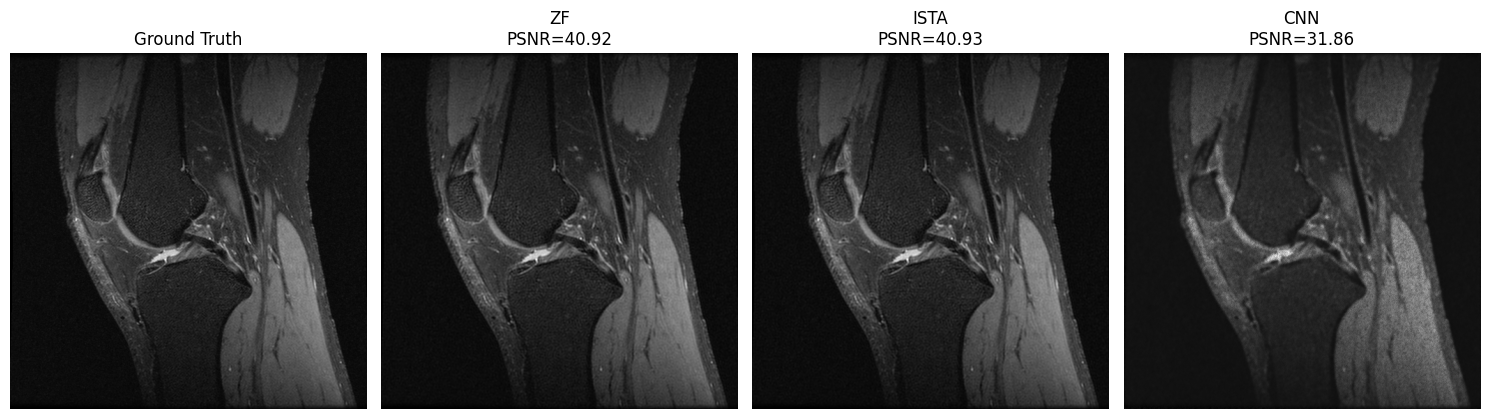

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pywt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pydicom
import re
import time

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# --- Paths ---
base_kaggle_input_path = '/kaggle/input/'
dataset_name = 'uc-berkeley-mri-dataset-case1'
dicom_dir = os.path.join(base_kaggle_input_path, dataset_name, 'P1_dcm/P1_dcm/')
kspace_cfl_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/kspace.cfl')
params_path = os.path.join(base_kaggle_input_path, dataset_name, 'P1/p1/e1/s1/params.txt')

# --- Lightweight CNN (Mini U-Net) ---
class MiniUNet(nn.Module):
    def __init__(self, img_size=512):
        super(MiniUNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bottleneck = nn.Conv2d(128, 256, 3, padding=1)
        self.dec3 = nn.Conv2d(384, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dropout = nn.Dropout(0.3)  # Added dropout

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        b = self.relu(self.bottleneck(self.pool(e3)))
        d3 = self.relu(self.dec3(torch.cat([self.upsample(b), e3], dim=1)))
        d2 = self.relu(self.dec2(torch.cat([self.upsample(d3), e2], dim=1)))
        d1 = self.relu(self.dec1(torch.cat([self.upsample(d2), e1], dim=1)))
        out = self.out(self.dropout(d1))
        return out

# --- Load DICOM ---
def load_dicom(dicom_path):
    if not os.path.exists(dicom_path):
        raise FileNotFoundError(f"DICOM file not found: {dicom_path}")
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)
    if img.shape != (512, 512):
        from skimage.transform import resize
        img = resize(img, (512, 512), anti_aliasing=True)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# --- Read params.txt ---
def read_params_dims(params_path):
    if not os.path.exists(params_path):
        print("params.txt not found. Using defaults: 320x320, 8 coils, 256 slices")
        return 320, 320, 8, 256
    try:
        with open(params_path, 'r') as f:
            lines = f.readlines()
            rows, cols, coils, slices = 320, 320, 8, 256  # Defaults from params.txt
            for line in lines:
                line = line.strip().lower()
                if 'rhnframes yres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        rows = nums[0]
                if 'rhfrsize xres' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        cols = nums[0]
                if 'rhnslices' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        slices = nums[0]
                if 'coils' in line or 'channels' in line:
                    nums = [int(x) for x in re.findall(r'\d+', line)]
                    if nums:
                        coils = nums[0]
            return rows, cols, coils, slices
    except Exception as e:
        print(f"Error reading params.txt: {e}")
        return 320, 320, 8, 256

# --- Read k-space .cfl ---
def read_cfl_data(cfl_path, dims):
    if not os.path.exists(cfl_path):
        return None
    try:
        data = np.fromfile(cfl_path, dtype=np.float32)
        expected_size = 2 * np.prod(dims)
        if data.size != expected_size:
            print(f"CFL size mismatch. Expected {expected_size}, got {data.size}. Expected size (MB): {expected_size*4/1024**2:.2f}, Actual: {data.size*4/1024**2:.2f}")
            return None
        complex_data = data[::2] + 1j * data[1::2]
        kspace_data = complex_data.reshape(dims, order='F')
        return kspace_data
    except Exception as e:
        print(f"Error reading .cfl: {e}")
        return None

# --- Zero-pad k-space ---
def zero_pad_kspace(kspace, target_shape=(512, 512)):
    rows, cols = kspace.shape[:2]
    target_rows, target_cols = target_shape
    pad_rows_top = (target_rows - rows) // 2
    pad_rows_bottom = target_rows - rows - pad_rows_top
    pad_cols_left = (target_cols - cols) // 2
    pad_cols_right = target_cols - cols - pad_cols_left
    kspace_padded = np.pad(kspace, ((pad_rows_top, pad_rows_bottom), (pad_cols_left, pad_cols_right)),
                           mode='constant', constant_values=0)
    return kspace_padded

# --- Variable Density Mask ---
def create_variable_density_mask(shape, acceleration_factor, center_fraction=0.08, poly_degree=2, seed=0):
    np.random.seed(seed)
    rows, cols = shape
    center_x, center_y = cols // 2, rows // 2
    x_coords = np.abs(np.arange(cols) - center_x)
    y_coords = np.abs(np.arange(rows) - center_y)
    dist_x, dist_y = np.meshgrid(x_coords, y_coords)
    norm_dist_x = dist_x / (np.max(dist_x) if np.max(dist_x) > 0 else 1)
    norm_dist_y = dist_y / (np.max(dist_y) if np.max(dist_y) > 0 else 1)
    pdf = (1 - norm_dist_x**poly_degree) * (1 - norm_dist_y**poly_degree)
    pdf = np.clip(pdf, 0, 1)
    target_samples = int(np.prod(shape) / acceleration_factor)
    flat_pdf = pdf.flatten()
    sorted_indices = np.argsort(-flat_pdf)
    mask = np.zeros(shape, dtype=bool).flatten()
    mask[sorted_indices[:target_samples]] = True
    mask = mask.reshape(shape)
    center_rows_abs = int(shape[0] * center_fraction)
    center_cols_abs = int(shape[1] * center_fraction)
    r_start, r_end = shape[0]//2 - center_rows_abs//2, shape[0]//2 + center_rows_abs//2
    c_start, c_end = shape[1]//2 - center_cols_abs//2, shape[1]//2 + center_cols_abs//2
    mask[r_start:r_end, c_start:c_end] = True
    actual_accel = np.prod(shape) / np.sum(mask)
    print(f"Variable Density Mask: Target R={acceleration_factor}, Actual R={actual_accel:.2f}")
    return mask

# --- ISTA ---
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def wavelet_forward(image, wavelet='db4', level=3):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr, coeff_slices

def wavelet_inverse(arr, coeff_slices, wavelet='db4'):
    coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs_from_arr, wavelet=wavelet)

def ista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val,
                    ground_truth_for_psnr, wavelet='db4', level=3):
    x_recon = initial_image.copy().astype(np.complex128)
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    step_size = 1.0
    for i in range(n_iters):
        current_k_space = fftshift(fft2(x_recon))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        grad_data_term = ifft2(ifftshift(k_space_error * mask))
        x_intermediate = x_recon - step_size * grad_data_term
        x_intermediate_real = np.real(x_intermediate)
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        threshold = lambda_val * step_size
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size
        coeffs_arr_thresh = coeffs_arr.copy()
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        x_reconstructed_real = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet)
        x_recon = x_reconstructed_real.astype(np.complex128)
        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"ISTA Iter {i+1}/{n_iters}, PSNR={current_psnr:.3f}")
    return np.clip(np.real(x_recon), 0, 1)

# --- Prepare CNN input ---
def prepare_cnn_input(undersampled_kspace, mask):
    zf_img = ifft2(ifftshift(undersampled_kspace))
    zf_real = np.real(zf_img)
    zf_imag = np.imag(zf_img)
    zf_real = (zf_real - zf_real.min()) / (zf_real.max() - zf_real.min() + 1e-8)
    zf_imag = (zf_imag - zf_imag.min()) / (zf_imag.max() - zf_imag.min() + 1e-8)
    input_tensor = torch.tensor(np.stack([zf_real, zf_imag], axis=0), dtype=torch.float32)
    return input_tensor.unsqueeze(0), np.abs(zf_img)

# --- Train CNN ---
def train_cnn(model, image, mask, epochs=500, lr=0.00005):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    k_space_undersampled = fftshift(fft2(image)) * mask
    input_tensor, zf_img = prepare_cnn_input(k_space_undersampled, mask)
    input_tensor = input_tensor.to(device)
    target_img = torch.tensor(image[None, None], dtype=torch.float32).to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)
        mse_loss = criterion(output, target_img)
        l1_loss = 0.0001 * torch.abs(output).mean()  # Reduced L1 weight
        loss = mse_loss + l1_loss
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, MSE: {mse_loss.item():.4f}, L1: {l1_loss.item():.4f}')
            torch.cuda.empty_cache()
    return model

# --- Evaluate ---
def evaluate_reconstruction(img_recon, img_ref):
    img_recon = np.clip(img_recon, 0, 1)
    img_ref = np.clip(img_ref, 0, 1)
    psnr_val = psnr(img_ref, img_recon, data_range=1.0)
    ssim_val = ssim(img_ref, img_recon, data_range=1.0)
    return psnr_val, ssim_val

# --- Main (Sec_128.mag) ---
def main_sec_128():
    # Load DICOM
    dicom_path = os.path.join(dicom_dir, 'Sec_128.mag')
    ground_truth = load_dicom(dicom_path)
    plt.imsave('original.png', ground_truth, cmap='gray')

    # Load k-space
    rows, cols, coils, slices = read_params_dims(params_path)
    dims = (rows, cols, coils, slices)
    kspace_data = read_cfl_data(kspace_cfl_path, dims)
    slice_idx = 128
    if kspace_data is None or slice_idx >= dims[3]:
        print("Using DICOM-based k-space")
        k_space_full = fftshift(fft2(ground_truth))
    else:
        # Map slice based on physical position (0.6mm thickness, 256 slices)
        slice_thickness = 0.6  # mm
        total_thickness = slice_thickness * slices
        target_position = (slice_idx / 256) * total_thickness
        best_psnr = -np.inf
        best_kspace_2d = None
        best_slice = slice_idx
        for offset in range(-20, 21):
            test_idx = slice_idx + offset
            if 0 <= test_idx < dims[3]:
                test_position = (test_idx / 256) * total_thickness
                position_diff = abs(test_position - target_position)
                kspace_slice = kspace_data[:, :, :, test_idx]
                image_slice = ifft2(ifftshift(kspace_slice, axes=(0, 1)), axes=(0, 1))
                image_rss = np.sqrt(np.sum(np.abs(image_slice)**2, axis=2))
                kspace_test = zero_pad_kspace(fftshift(fft2(image_rss)))
                kspace_recon = np.abs(ifft2(ifftshift(kspace_test)))
                kspace_recon = (kspace_recon - kspace_recon.min()) / (kspace_recon.max() - kspace_recon.min() + 1e-8)
                test_psnr = psnr(ground_truth, kspace_recon, data_range=1.0)
                print(f"Slice {test_idx} (offset {offset}, pos {test_position:.2f}mm): PSNR={test_psnr:.2f}")
                if test_psnr > best_psnr:
                    best_psnr = test_psnr
                    best_kspace_2d = kspace_test
                    best_slice = test_idx
        if best_psnr > 30:
            k_space_full = best_kspace_2d
            print(f"Selected k-space slice {best_slice} (PSNR={best_psnr:.2f})")
        else:
            print(f"Best k-space PSNR too low ({best_psnr:.2f}, slice {best_slice}). Using DICOM k-space.")
            k_space_full = fftshift(fft2(ground_truth))

    # Variable Density Mask
    mask = create_variable_density_mask(k_space_full.shape, acceleration_factor=4)
    plt.imsave('mask.png', mask, cmap='gray')

    # Zero-Filled
    start_time = time.time()
    k_space_undersampled = k_space_full * mask
    img_zf = np.abs(ifft2(ifftshift(k_space_undersampled)))
    zf_time = time.time() - start_time
    zf_psnr, zf_ssim = evaluate_reconstruction(img_zf, ground_truth)
    print(f'Zero-Filled: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    plt.imsave('img_zf.png', img_zf, cmap='gray')

    # ISTA
    start_time = time.time()
    img_ista = ista_wavelet_cs(k_space_undersampled, mask, img_zf.copy(),
                               n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=ground_truth)
    ista_time = time.time() - start_time
    ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, ground_truth)
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    plt.imsave('img_ista.png', img_ista, cmap='gray')

    # CNN
    model = MiniUNet(img_size=512)
    start_time = time.time()
    try:
        trained_model = train_cnn(model, ground_truth, mask, epochs=500, lr=0.00005)
        input_tensor, _ = prepare_cnn_input(k_space_undersampled, mask)
        with torch.no_grad():
            output = trained_model(input_tensor.to(device))
            img_cnn = output.squeeze().cpu().numpy()
        cnn_time = time.time() - start_time
        cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, ground_truth)
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')
        plt.imsave('img_cnn.png', img_cnn, cmap='gray')
    except RuntimeError as e:
        print(f"CNN training failed: {e}. Try reducing epochs or using CPU.")
        cnn_psnr, cnn_ssim, cnn_time = -1, -1, -1

    # Compare
    print('\nComparison:')
    print(f'Your ISTA: PSNR=40.929, SSIM=0.9614, Time=0.47s')
    print(f'Paper Edge-Enhanced (R=4): PSNR=33.52, SSIM=0.4206 (TV)')
    print(f'ZF: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}, Time={zf_time:.2f}s')
    print(f'ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}, Time={ista_time:.2f}s')
    if cnn_psnr != -1:
        print(f'CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Time={cnn_time:.2f}s')

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img_zf, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}')
    plt.axis('off')
    if cnn_psnr != -1:
        plt.subplot(1, 4, 4)
        plt.imshow(img_cnn, cmap='gray')
        plt.title(f'CNN\nPSNR={cnn_psnr:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- OASIS Pipeline ---
def main_oasis(oasis_paths, slice_indices, img_size=256):
    import nibabel as nib
    images = []
    for path, slice_idx in zip(oasis_paths, slice_indices):
        try:
            nii = nib.load(path)
            img = nii.get_fdata()[:, :, slice_idx].astype(np.float32)
            if img.shape != (img_size, img_size):
                from skimage.transform import resize
                img = resize(img, (img_size, img_size), anti_aliasing=True)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            images.append(img)
        except Exception as e:
            print(f"Error loading OASIS {path}: {e}")
            continue

    if not images:
        print("No OASIS images loaded.")
        return

    # Train CNN on multiple slices
    model = MiniUNet(img_size=img_size)
    mask = create_variable_density_mask((img_size, img_size), acceleration_factor=4)
    start_time = time.time()
    try:
        for img in images:
            trained_model = train_cnn(model, img, mask, epochs=100, lr=0.00005)
            model = trained_model  # Update model
        cnn_train_time = time.time() - start_time

        # Evaluate on first slice
        img = images[0]
        k_space_undersampled = fftshift(fft2(img)) * mask
        input_tensor, zf_img = prepare_cnn_input(k_space_undersampled, mask)
        with torch.no_grad():
            output = trained_model(input_tensor.to(device))
            img_cnn = output.squeeze().cpu().numpy()
        cnn_psnr, cnn_ssim = evaluate_reconstruction(img_cnn, img)
        print(f'OASIS CNN: PSNR={cnn_psnr:.3f}, SSIM={cnn_ssim:.4f}, Train Time={cnn_train_time:.2f}s')
        plt.imsave('oasis_img_cnn.png', img_cnn, cmap='gray')

        # ZF and ISTA for comparison
        zf_psnr, zf_ssim = evaluate_reconstruction(zf_img, img)
        img_ista = ista_wavelet_cs(k_space_undersampled, mask, zf_img.copy(),
                                   n_iters=10, lambda_val=0.0001, ground_truth_for_psnr=img)
        ista_psnr, ista_ssim = evaluate_reconstruction(img_ista, img)
        print(f'OASIS ZF: PSNR={zf_psnr:.3f}, SSIM={zf_ssim:.4f}')
        print(f'OASIS ISTA: PSNR={ista_psnr:.3f}, SSIM={ista_ssim:.4f}')
        plt.imsave('oasis_img_zf.png', zf_img, cmap='gray')
        plt.imsave('oasis_img_ista.png', img_ista, cmap='gray')
    except RuntimeError as e:
        print(f"OASIS CNN training failed: {e}")
        return

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('OASIS Ground Truth')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(zf_img, cmap='gray')
    plt.title(f'ZF\nPSNR={zf_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(img_ista, cmap='gray')
    plt.title(f'ISTA\nPSNR={ista_psnr:.2f}')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(img_cnn, cmap='gray')
    plt.title(f'CNN\nPSNR={cnn_psnr:.2f}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main_sec_128()
    # Example OASIS run (uncomment with paths)
    # oasis_paths = ['/path/to/OAS1_0208.nii', '/path/to/OAS1_0209.nii']
    # slice_indices = [81, 81]
    # main_oasis(oasis_paths, slice_indices, img_size=256)

In [ ]:
def fista_wavelet_cs(k_space_undersampled, mask, initial_image, n_iters, lambda_val, ground_truth_for_psnr, wavelet='db4', level=3):
    x_recon = initial_image.copy().astype(np.complex128)
    k_space_undersampled = k_space_undersampled.astype(np.complex128)
    step_size = 1.0
    t = 1.0
    z = x_recon.copy()
    for i in range(n_iters):
        current_k_space = fftshift(fft2(z))
        k_space_error = (current_k_space * mask) - k_space_undersampled
        grad_data_term = ifft2(ifftshift(k_space_error * mask))
        x_intermediate = z - step_size * grad_data_term
        x_intermediate_real = np.real(x_intermediate)
        coeffs_arr, coeff_slices = wavelet_forward(x_intermediate_real, wavelet=wavelet, level=level)
        threshold = lambda_val * step_size
        coeffs_list_form = pywt.wavedec2(x_intermediate_real, wavelet=wavelet, level=level)
        approx_coeffs_size = coeffs_list_form[0].size
        coeffs_arr_thresh = coeffs_arr.copy()
        coeffs_arr_thresh[approx_coeffs_size:] = soft_threshold(coeffs_arr[approx_coeffs_size:], threshold)
        x_new = wavelet_inverse(coeffs_arr_thresh, coeff_slices, wavelet=wavelet).astype(np.complex128)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = x_new + ((t - 1) / t_new) * (x_new - x_recon)
        x_recon = x_new
        t = t_new
        if (i + 1) % (n_iters // 10 or 1) == 0 or i == n_iters - 1:
            current_psnr = psnr(ground_truth_for_psnr, np.clip(np.real(x_recon), 0, 1), data_range=1.0)
            print(f"FISTA Iteration {i+1}/{n_iters}, Current PSNR: {current_psnr:.4f} dB")
    return np.clip(np.real(x_recon), 0, 1)